In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sopt
from pysimu import ode2numba, ssa

from ipywidgets import *


In [2]:
%matplotlib notebook

## System definition 

In [3]:
sys = { 't_end':20.0,'Dt':0.01,'solver':'forward-euler', 'decimation':10, 'name':'smib_1',
   'models':[{'params':
                   {'Omega_b' : 2*np.pi*50.0,
                    'H'  : 6.0,
                    'K_d'  : 10.0,
                    'T_d'  : 10.0,
                    'R_s'  : 0.1,
                    'X_s'  : 0.3 ,
                    'K_f'  : 0.3, 
                    'T_f'  : 1.0, 
                    'K_q'  : 10.0,   
                    'T_q'  : 1.0,
                    'K_a'  : 0.0,     
                    'T' : 0.01,
                    'B_s0':0.0,
                    'G_s_inf':0.0,
                    'B_s_inf':-10,
                    'G_s0':0.01,
                    'V_inf':1.0},
              'f':[
                    'dtheta_inf = Omega_b*(omega_ref)',
                    'ddelta  =  Omega_b*(omega - omega_ref)',
                    'domega = (p_m - p_e - p_d)/(2*H)',
                    'di_s_d = (i_s_d_ref - i_s_d)/T',
                    'di_s_q = (i_s_q_ref - i_s_q)/T',
                    'dxi_q  =  epsilon_q',
                   ],
              'g':[  'e_d@ e_d - e*cos(delta - theta_s)',
                     'e_q@ e_q - e*sin(delta - theta_s)',
                     'e@   e_0 + K_q*(epsilon_q + xi_q/T_q) ',
                     'v_s_d@ e_d - R_s*i_s_d_ref + X_s*i_s_q_ref - v_s_d',
                     'v_s_q@ e_q - R_s*i_s_q_ref - X_s*i_s_d_ref - v_s_q',
                     'P_t@ i_s_d*v_s_d - P_t + i_s_q*v_s_q',
                     'Q_t@ i_s_d*v_s_q - Q_t - i_s_q*v_s_d',
                     'theta_s @(G_t0 + G_t_inf)*V_s**2 - V_inf*(G_t_inf*cos(theta_s - theta_inf) + B_s_inf*sin(theta_s - theta_inf))*V_s - P_s',
                     'V_s  @ (- B_s0 - B_s_inf)*V_s**2 + V_inf*(B_t_inf*cos(theta_s - theta_inf) - G_s_inf*sin(theta_s - theta_inf))*V_s - Q_s',
                     'p_e@ i_s_d * e_d + i_s_q*e_q - p_e',
                     'q_s@ i_s_q * v_s_d - i_s_d*v_s_q - q_s'],
              'u':{'p_m':0.9,'V_ref':1.0}, 
              'u_ini':{'P_t', 'Q_t'},
              'y_ini':[  'e_d',  'e_q',  'e',  'e_0','v_q', 'P_t', 'Q_t', 'theta_t','V_t' , 'v_f','v_pss', 'omega_w'],
              'h':[
                   'omega'
                   ]}
              ],
    'perturbations':[{'type':'step','time':1.0,'var':'V_ref','final':1.01} ]
    }

x,f = ode2numba.system(sys)  

UnboundLocalError: local variable 'N' referenced before assignment

In [4]:
import smib_1

In [5]:
syst = smib_1.smib_1_class()
x0 = np.ones(syst.N_x+syst.N_y)
s = sopt.fsolve(syst.run_problem,x0 )
print(s)

[ 1.21635924e+00  1.00000000e+00  8.78709249e-01  4.53041959e-01
  9.88747411e-01 -1.35145571e-17  1.00000000e+00  9.08482531e-01
  4.08145909e-01  9.00000000e-01  6.54389466e-01  7.41212432e-01
  8.97024229e-01  4.06292159e-01  4.93092846e-01  9.88747411e-01
  2.25051787e+00 -1.52748202e-16 -1.35145571e-17]


<IPython.core.display.Javascript object>


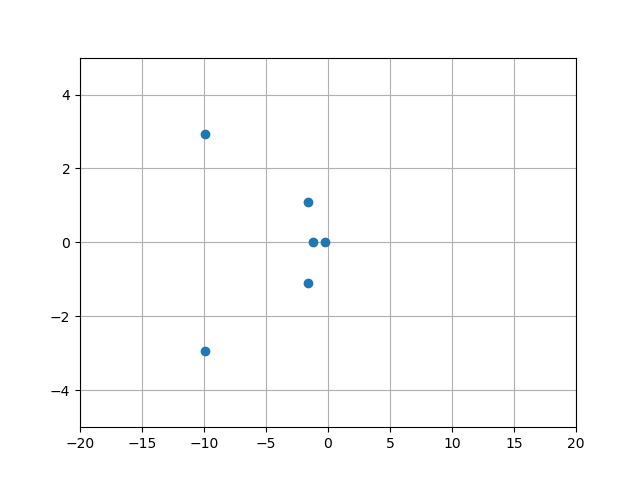

In [6]:
fig,axes = plt.subplots(nrows=1)
points = axes.plot([],[],'o')
axes.set_xlim(-20,20)
axes.set_ylim(-5,5)
axes.grid(True)
def Jac(x):
  
    J=np.vstack((np.hstack((syst.struct[0].Fx,syst.struct[0].Fy)),np.hstack((syst.struct[0].Gx,syst.struct[0].Gy))))
    return J

def update(p_m = 0.9, K_stab=5):
    syst.struct[0].p_m = p_m
    syst.struct[0].K_stab = K_stab
    x0 = np.vstack([syst.struct[0].x, syst.struct[0].y])
    x0 = np.ones(syst.N_x+syst.N_y)
    #x0[0,0] = 0.0

    frime = np.vstack((syst.struct[0].f,syst.struct[0].g))
    s = sopt.fsolve(syst.run_problem,x0 )
    syst.struct[0].x[:,0] = s[0:syst.N_x]
    syst.struct[0].y[:,0] = s[syst.N_x:(syst.N_x+syst.N_y)]
    #print(np.linalg.det(syst.struct[0].Gy))
    e,v = np.linalg.eig(ssa.eval_A(syst))
    points[0].set_xdata(e.real)
    points[0].set_ydata(e.imag/np.pi/2)
    delta = np.rad2deg(syst.struct[0].x[0,0])
    print(delta)
    fig.canvas.draw()

In [7]:
interact(update);

interactive(children=(FloatSlider(value=0.9, description='p_m', max=2.7, min=-0.9), IntSlider(value=5, descrip…

In [8]:
np.linalg.det(syst.struct[0].Gy)

2.6100598166857147

In [9]:
update()

69.69225089109958
